In [84]:

import numpy as np
import os
import pickle as pkl
import json
from matplotlib import pyplot as plt
from scipy.stats import expon, norm, gamma

In [30]:
dataset_location = "D:/MASC/deep_learning_processed_dataset"

In [42]:
gaze_path = os.path.join(*[dataset_location, "tgaze"])
aversion_label_path = os.path.join(*[dataset_location, "taversion_label"])
video_metadata_path = os.path.join(*[dataset_location, "metadata.json"])

In [55]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.3):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals
def switch_rate_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    total_in = np.sum(in_cluster)
    # switch rate (we want to maximize the number of gaze shifts between in cluster and out of cluster)
    # the rationale behind this is that gaze shifting outside the cluster 
    swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
    rtv = -swtich
    return rtv, total_in
def intra_cluster_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    rtv = np.sum(dist * in_cluster)
    total_in = np.sum(in_cluster)
    rtv = rtv / total_in
    return rtv, total_in
def radius_line_search(points, center, min_member, max_iter=7):
    center = np.expand_dims(center, axis=0)
    radius_max = 20
    radius_min = 1
    for i in range(0, max_iter):
        clustering_goodness_max_r, total_in= switch_rate_distance(points, center, radius_max)
        clustering_goodness_min_r, total_in= switch_rate_distance(points, center, radius_min)
        if clustering_goodness_max_r <= clustering_goodness_min_r and total_in >= min_member:
            radius_max = (radius_max + radius_min)/2
        else:
            radius_min = (radius_max + radius_min)/2
        
    return radius_min   
def find_gaze_target(fixations, gaze_points, vertical_sensitivity=1):

    fixations[:, 1] = fixations[:, 1] * vertical_sensitivity
    gaze_points[:, 1] = gaze_points[:, 1] * vertical_sensitivity
    if fixations.shape[0] <= 2:
        return np.ones((fixations.shape[0], ))

    mixture = GaussianMixture(int(np.minimum(8, fixations.shape[0]))).fit(fixations[:, :2], )
    mix = mixture.predict_proba(fixations[:, :2])
    # get cluster heads
    mixture_centers = mixture.means_
    # find the index of the most likely target
    most_likely_target = np.argmax(np.sum(mix, axis=0))
    most_likely_cluster_member_count = np.where(np.argmax(mix, axis=1) == most_likely_target, 1, 0).sum()
    # find the most likely look at point
    gaze_target = mixture_centers[most_likely_target]
    distance_to_target = np.linalg.norm(gaze_points[:, :2] - np.expand_dims(gaze_target, axis=0), axis=1)
    # use line search to find an appropriete radious of what to include
    radius = radius_line_search(fixations[:, :2], gaze_target, most_likely_cluster_member_count, 7)
    looked_at = np.where(distance_to_target < radius, 1, 0)
    return looked_at

In [56]:
with open(video_metadata_path, "r") as f:
    video_metadata = json.load(f)["data"]

In [66]:
fixation_length = []
for i in range(0, len(video_metadata)):
    file_name = video_metadata[i]["name"]
    fps = video_metadata[i]["fps"]
    # get paths
    gaze_file_location = os.path.join(gaze_path, file_name+".pkl")
    gaze_label_file_location = os.path.join(aversion_label_path, file_name+".pkl")
    try:
        with open(gaze_file_location, "rb") as f:
            gaze = pkl.load(f)
    except:
        continue
    with open(gaze_label_file_location, 'rb') as f:
        gaze_label = pkl.load(f)
    ts = np.arange(0, gaze.shape[0]) / fps
    fixations, fixations_intervals = dispersion_filtering(ts, gaze, dispersion_threshold=6, duraiton_threshold=0.2)
    for ii in range(0, len(fixations_intervals)):
        start, end = fixations_intervals[ii]
        direct_gaze_or_no = gaze_label[start:end].mean()
        if direct_gaze_or_no < 0.5:
            fixation_length.append(fixations[ii, 2])  

0.5675324729140843 0.19999999999999998 0.4179946887112737


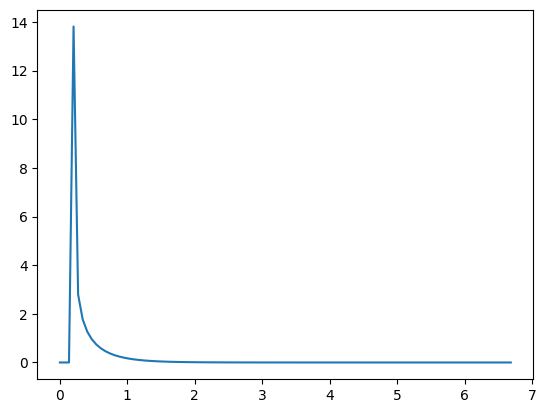

In [91]:
shape, loc, scale = gamma.fit(fixation_length)
print(shape, loc, scale)
x = np.linspace(0, np.max(fixation_length), 100)
plt.plot(x, gamma.pdf(x, shape, loc=loc, scale=scale))
# samples = gamma.rvs(shape, loc=loc, scale=scale, size=100000)
# plt.hist(samples, weights=[1/100000]*100000)